In the next few posts I'd like to discuss a fun project I've been procrastinating things with recently - a parallelizable (up to the GPU level) Python Numpy implementation of the 2D [Ising model](https://en.wikipedia.org/wiki/Ising_model), which I won't introduce at length here because it's been covered really well in multiple places out there and I'd rather not repeat them.

The gist of it is that we have a grid of discrete spins represented by integers, +1 for spin up and -1 for spin down. Each spin interacts with its nearest neighbors via a sum of products of that spin's value and the neighbor's value, times minus a positive constant J. The minus is there so that spins pointing the same way decrease the total energy and spins pointing in the opposite direction increase it.
<!-- TEASER_END -->
Let's get to it!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

For now, we'll run a 16x16 grid, representing spin up as black and spin down as white.

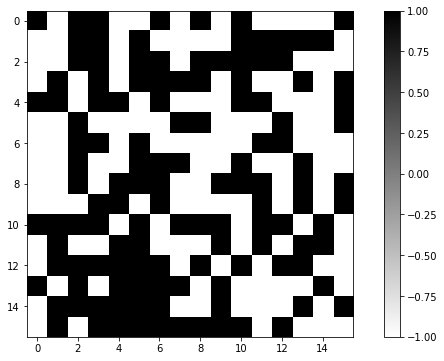

In [25]:
plt.rcParams['figure.figsize'] = [11, 6]  # for larger pictures
plt.rcParams['image.cmap'] = 'plasma'    # well duh
size = (16, 16)

np.random.seed(20)
a = np.random.randint(low=0, high=2, size=size) * 2 - 1
plt.imshow(a, cmap='binary')
plt.colorbar();

The usual Monte Carlo Markov Chain ([Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)) implementation for this goes like this:

1. pick a spin (point on the grid) at random
2. calculate the change in energy $\Delta E$ that would result from flipping it
3. use that change in energy to figure out how likely the flipped state is via a Boltzmann $\exp(\beta \Delta E)$ factor (clearly non-negative), calculated from interactions with neighboring spins
4. use that probability with an uniformly-distributed random number to reject or accept the state with the flipped state
5. run a boatload of iterations

It's a nice algorithm, don't get me wrong - but it seems needlessly complex to parallelize if you're just picking one spin at a time. Why not try to flip every spin at a time? Let's try that!

First up, for each spin, we'll calculate its interaction terms, with periodic boundary conditions. This just means that for each spin, we add up the sum of its neighbors' spins (check the math, it really works like that), reaching to the other side on the edges. `numpy.roll` is amazing for that:

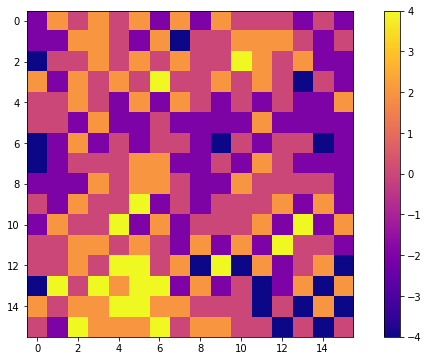

In [26]:
interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
plt.imshow(interactions)
plt.colorbar();

We'll just keep our constants "reasonable" (equal to 1), as simulationistas are wont to do. We'll keep writing them though, so as to keep in mind where they should go in. The full energy is just the local spin's value times its neighbors' spins (the local spin factors out of the sum), times a constant:

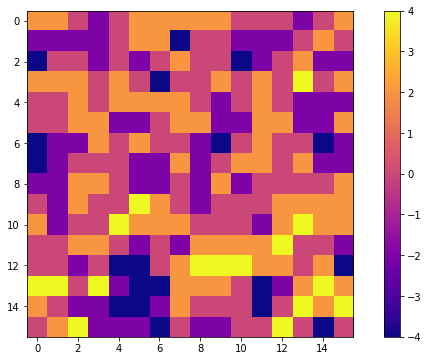

In [28]:
J = 1 # a material constant defining the strength of the interaction

current_energy = - J * a * interactions
plt.imshow(current_energy)
plt.colorbar();

We'd expect the low energy spins to remain as they are, and the high energy spins to flip, so as to decrease the system's energy.

It's also simple to calculate the change in energy: boldly keeping the `interaction` terms constant, we just change the sign on `a`, so:

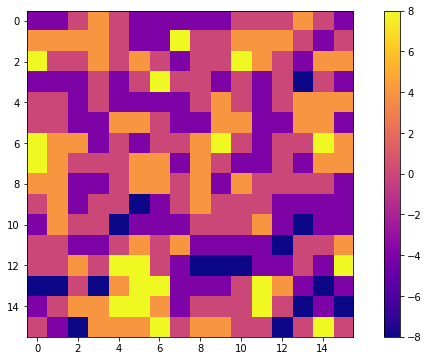

In [29]:
deltaE = 2 * J * a * interactions # = final state - initial state = -J interactions * ( (-a) - (a) )
plt.imshow(deltaE)
plt.colorbar();

Let's now get the Boltzmann factor:

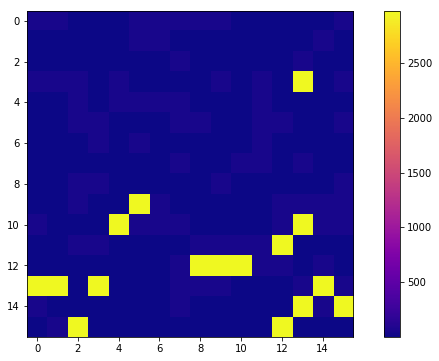

In [30]:
beta = 1 # inverse thermal energy 1 / (k_B*T)
boltzmann = np.exp(-beta * deltaE)
plt.imshow(boltzmann)
plt.colorbar();

Ouch, look at that colorbar! Note that we're only comparing the Boltzmann factor (which is in the range of $[0, \infty)$ ) with a standard (phew, almost callled it a *normal*) random number with a uniform distribution from the $(0, 1)$ range. I'm not going to bother paying attention to the boundaries because they're infinitely unlikely for floats anyway.

Thus, a "better" (though admittedly uglier) plot that shows spins that are definitely going to flip in yellow is:

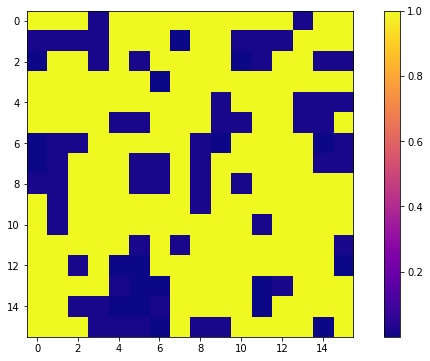

In [32]:
plt.imshow(boltzmann, vmax = 1)
plt.colorbar();

Given how ugly this plot was, let's take a quick look at the distribution of these Boltzmann factors, inverstigating their arguments first:

In [33]:
np.unique(-beta * deltaE)

array([-8, -4,  0,  4,  8])

And now the actual Boltzmann factors, though we'll just force each one above 1 to be 1 exactly:

In [34]:
np.unique(boltzmann)

array([3.35462628e-04, 1.83156389e-02, 1.00000000e+00, 5.45981500e+01,
       2.98095799e+03])

In other words, because of the discrete and simple ($s = \pm1$) nature of the system, there are only a few possiblities.

We still need to figure out which spins will actually be flipped. That's quite simple as well.

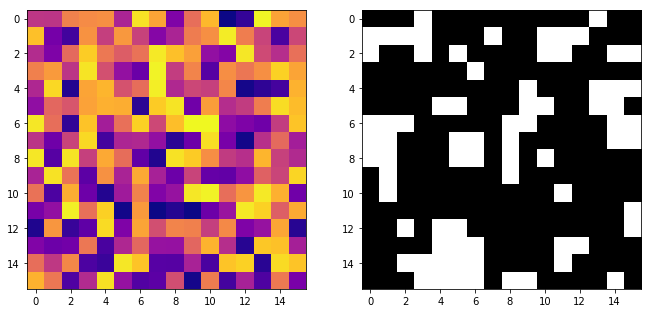

In [10]:
randoms = np.random.random(size)
flip_these = randoms < boltzmann

_, axes = plt.subplots(ncols=2)
axes[0].imshow(randoms);
axes[1].imshow(flip_these.astype(int), cmap='binary');

Note that we can now show the difference between which spins are definitely going to be flipped, and which spins are just "randomly" flipped:

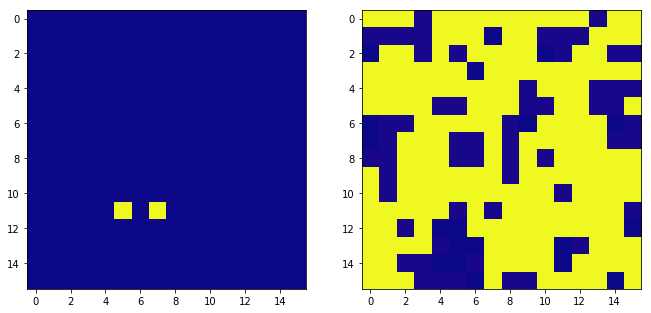

In [11]:
flip_these_for_sure = boltzmann >= 1
_, axes = plt.subplots(ncols=2)
axes[0].imshow(flip_these ^ flip_these_for_sure)
axes[1].imshow(boltzmann, vmax = 1);

It's not many, but it's important to take those into account! And now we flip all of them, with a "before vs after" picture:

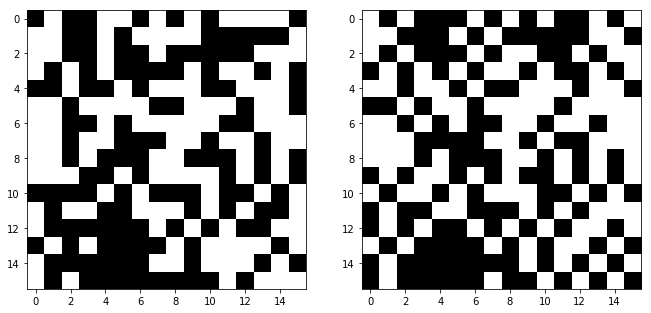

In [35]:
a_new = a.copy() # I'm keeping `a` for plotting, but you could certainly do it in-place

a_new[flip_these] *= -1

_, axes = plt.subplots(ncols=2)
axes[0].imshow(a, cmap='binary')
axes[1].imshow(a_new, cmap = 'binary');

Did that work? Well... not quite, as you may already see. We made a little assumption in there that is going to mess this up. Let me just resummarize the computational loop really quickly, and check that I did so correctly. Note how the actual code is pretty short, too.

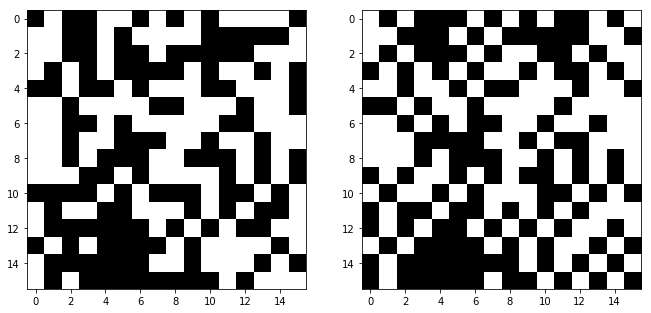

In [37]:
def iteration(a, J = 1, beta = 1):
    interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
    deltaE = 2 * J * a * interactions
    boltzmann = np.exp(-beta * deltaE)
    flip_these = np.random.random(a.shape) < boltzmann
    new_a = a.copy()     # this could be neglected for an in-place implementation
    new_a[flip_these] *= -1
    return new_a

_, axes = plt.subplots(ncols=2)
axes[0].imshow(a, cmap='binary')
axes[1].imshow(iteration(a), cmap = 'binary');

Do you see the problem yet? If not, this Python translation of a popular song should do it:

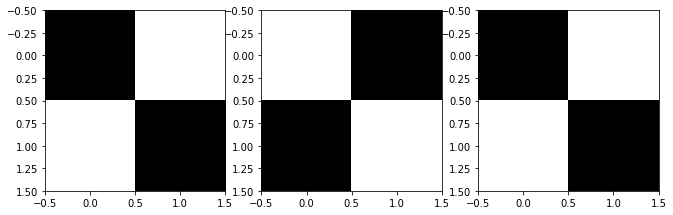

In [38]:
old_boss = np.array([[1, -1],       # excuse my variable naming
                    [-1, 1]])       # this is all part of the plan

_, axes = plt.subplots(ncols=3)
axes[0].imshow(old_boss, cmap='binary')

boss = iteration(old_boss)
axes[1].imshow(boss, cmap = 'binary');   # oh no...

new_boss = iteration(boss)
axes[2].imshow(new_boss, cmap = 'binary');  # oh, yeaaah

And if you haven't guessed yet:

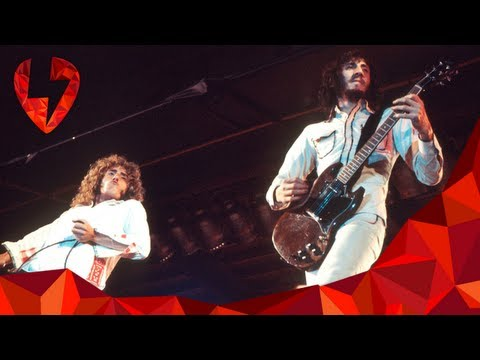

In [15]:
from IPython.display import YouTubeVideo
YouTubeVideo("zYMD_W_r3Fg", start=472)

Note how I am merciful and spared you from having to lower your volume beforehand! You can trust me with these things.

Remember that earlier we *boldly* (ctrl-f that if you don't recall!) kept the interaction terms constant. But that's a terrible mistake in terms of causality! Let's take a look at this again:

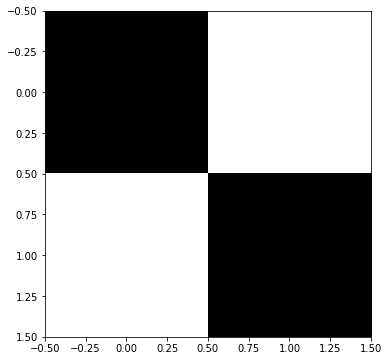

In [16]:
plt.imshow(new_boss, cmap='binary')

The black spins depend on the white spins for their energy calculation and vice versa. You can't update the white spins at the same time as the black ones are changing.

This pattern, though, provides a way out of this conundrum. We can use `old_boss` as a mask! We'll take turns updating the black and white spins this way.

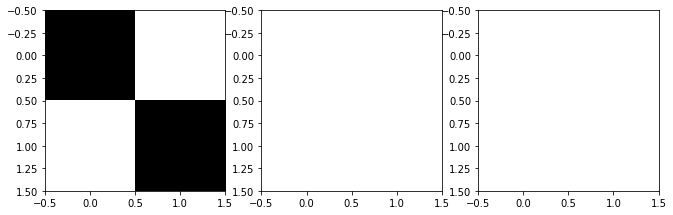

In [39]:
def better_iteration(a, mask, J = 1, beta = 1):
    interactions = np.roll(a, 1, 0) + np.roll(a, 1, 1) + np.roll(a, -1, 0) + np.roll(a, -1, 1)
    deltaE = 2 * J * a * interactions # = final state - initial state = interactions * ( (-a) - (a) )
    boltzmann = np.exp(-beta * deltaE) * mask    # this has been modified!
    flip_these = np.random.random(a.shape) < boltzmann
    new_a = a.copy()
    new_a[flip_these] *= -1
    return new_a

_, axes = plt.subplots(ncols=3)
axes[0].imshow(old_boss, cmap='binary')

better_boss = better_iteration(old_boss, mask=old_boss)
axes[1].imshow(better_boss, cmap = 'binary');

better_new_boss = better_iteration(better_boss, mask= 1 - old_boss) # note the negation here
axes[2].imshow(better_boss, cmap = 'binary');

And to demonstrate that this doesn't get us spurious updates on the full grid:

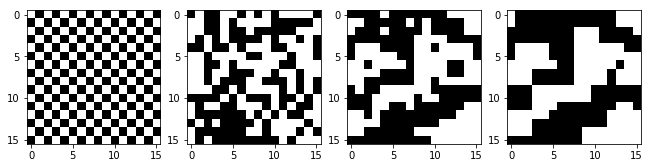

In [40]:
a_mask = np.ones_like(a)
a_mask[::2, ::2] = 0
a_mask[1::2, 1::2] = 0

def full_iteration(a, mask, J = 1, beta = 1):
    intermediate = better_iteration(a, mask, J, beta)
    return better_iteration(intermediate, 1-mask, J, beta)

_, axes = plt.subplots(ncols=4)
axes[0].imshow(a_mask, cmap='binary');
axes[1].imshow(a, cmap='binary')
axes[2].imshow(better_iteration(a, a_mask), cmap='binary')

final_a = full_iteration(a, a_mask)
axes[3].imshow(final_a, cmap = 'binary');

And I think we've earned this:

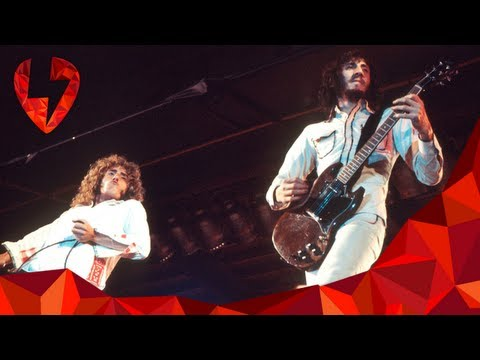

In [19]:
YouTubeVideo("zYMD_W_r3Fg", start=462) # headphone warning!

Let's do one last check:

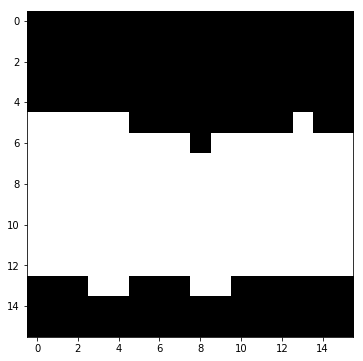

In [20]:
a_iterated = a.copy()
np.random.seed(0)
for i in range(10):
    a_iterated = full_iteration(a_iterated, a_mask)
plt.imshow(a_iterated, cmap='binary');

Well, that's certainly physical behavior, though annoying - stable domains are a hallmark of the 2D Ising model under the critical temperature of about 2.3 (with $k_b = 1$). At high temperatures, the system behaves more randomly:

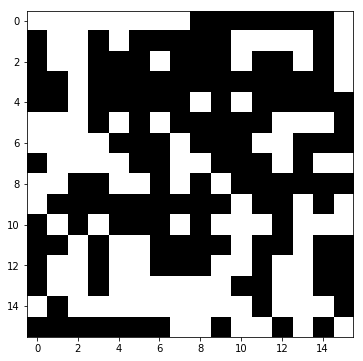

In [21]:
beta = 1 / (1 * 10)
a_iterated = a.copy()
np.random.seed(0)
for i in range(10):
    a_iterated = full_iteration(a_iterated, a_mask, beta = beta)
plt.imshow(a_iterated, cmap='binary');

While under the critical temperature, the long-term stable state is the single domain, all-spins-parallel state:

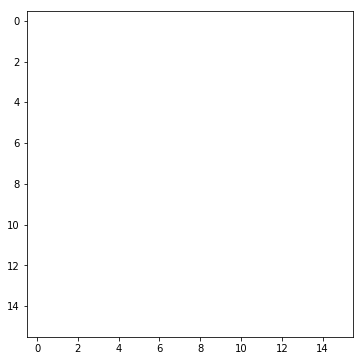

In [22]:
a_iterated = a.copy()
np.random.seed(0)
for i in range(1000):
    a_iterated = full_iteration(a_iterated, a_mask)
plt.imshow(a_iterated, cmap='binary');

And that beautiful plot is probably a good place to finish for today! Next up, benchmarking and optimization (as in, just straight up dumping this on the GPU)!